# Predicting Destinations with the Airbnb Dataset using Random forest Classifier

This notebook demonstrates the entire process of building a predictive model using Random forest to suggest the first destination of new Airbnb Users. All the processes involved, such as data wrangling, exploratory data analysis, inferential statistics.

In [2]:
import pandas as pd
import numpy as np
from random import randint
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt
import time

The first step is to load all the data available to us in a Pandas Dataframe and extract basic information such as number of samples, number of null values rows, number of features, etc. Here I have used Random forest classifier.

The next step would be to deal with the missing values using a suitable method (dropping, interpolating, etc.) and convert certain features into a more suitable form for applying inferential statistics and machine learning algorithms.

In [3]:
def findNA(df):
    df = df.replace(r'\s+', np.nan, regex=True)
    df = df.replace('-unknown-',np.nan, regex=False)
    df = df.replace('Other/Unknown',np.nan, regex=False)
    df = df.dropna(thresh=10) #Ignore the rows with majority Missing Value during Analysis
    return df

This function will remove '-unknown-' and 'Other/Unknown' values from the CSV file and return cleaned data frame.
Here I have set thresh value to 10. It means that in a single row at least 10 N/A values are allowed. 

In [5]:
def encodeDate(df):
    df['date_account_created']=pd.to_datetime(df['date_account_created']).dt.dayofweek
    df['date_first_booking']=pd.to_datetime(df['date_first_booking']).dt.dayofweek
    return df

encodeDate function will extract day of week from date_account_created and date_first_booking columns.

In [6]:
def weightedRandomImputation(df):
    for col in df:
        nan_count=df[col].isnull().sum()
        if col=='age':
            df=handleOutlierAge(df)
            
        # For parameters other then age, compute their missing value using stratified methodology of missing value imputation    
        if nan_count>0 and col!='age': 
            df_counts=df[col].value_counts()
            Total_minus_unknown = 0
            Total_minus_unknown = len(df[col]) - len(df_counts)
            ratio_list=[]
            for i in range(len(df_counts)):
                ratio_list.append(float(df_counts[i])*100/float(Total_minus_unknown))
            min_ratio = min(ratio_list)
            ratio_list = [int(x/min_ratio) for x in ratio_list]
            counts_list=df_counts.index.tolist()
            pairs = list(zip(ratio_list,counts_list))
            df[col]=df[col].apply(lambda x: weightedRandomHelper(pairs) if(pd.isnull(x)) else x)

        # Creating bins for signup_flow parameter
        if col=='signup_flow': 
            bins = [-1,5,10,15,20,28]
            group_names = [0,1,2,3,4]
            df['signup_flow_bins'] = pd.cut(df['signup_flow'], bins, labels=group_names)

    return df


The function weightedRandomImputation() takes data frame as an argument and removes outliers from age column.
For the columns other than age , if N/A value count is greater than zero then it will identify those values and replace it with the mean values.

Here I have created bins for signup_flow column.

In [7]:
def weightedRandomHelper(pairs):  
    total = sum(pair[0] for pair in pairs)
    r = randint(1, total)
    for (weight, value) in pairs:
        r -= weight
        if r <= 0: return value

In [8]:
def handleOutlierAge(df):
    df['age']=df['age'].apply(lambda x: datetime.now().year-x if x>1900 else x)
    
    #Valid age range between 14 to 90 as per data, otherwise check if its outlier or not
    df['age']=df['age'].apply(lambda x: x if 14<=x<=90 else np.nan)     
    mean = df['age'].mean()
    mean = int(mean)
    df['age']=df['age'].apply(lambda x: mean if np.isnan(x) else x) 
    return df

This function will remove outliers from age column.Here I have taken valid age range is between 14 to 90

In [17]:
def randomForestDecisionClassifier(df,df_test):
    print("\nLearning the Random Forest Classifier Model...")
    Y_train = df.country_destination
    X_train = df.drop('country_destination', 1)
    X_train = X_train.drop('id', 1)

    #preprocess of test
    Y_test = df_test.country_destination
    X_test = df_test.drop('country_destination', 1)
    X_test = X_test.drop('id', 1)

    # encode Y train
    le = LabelEncoder()
    Y_train = le.fit_transform(Y_train)

    X_train = X_train.apply(LabelEncoder().fit_transform)
    X_test= X_test.apply(LabelEncoder().fit_transform)

    # Encode Y Test 
    le_t = LabelEncoder()
    Y_test = le_t.fit_transform(Y_test)
    
    #dropping below columns as they do not improve the accuracy based on clf.feature_importances_
    X_train = X_train.drop('language', 1)
    X_train = X_train.drop('signup_app', 1)
    X_train = X_train.drop('signup_flow', 1)
    X_train = X_train.drop('timestamp_first_active', 1)
    X_test = X_test.drop('language', 1)
    X_test = X_test.drop('signup_app', 1)
    X_test = X_test.drop('signup_flow', 1)
    X_test = X_test.drop('timestamp_first_active', 1)

    clf = RandomForestClassifier(max_features= 'auto', max_depth = 20, random_state=10, min_samples_split = 4, verbose =1, class_weight = 'balanced', oob_score =False, n_estimators = 100)

    clf.fit(X_train, Y_train)
    print("Importance of the features : ",clf.feature_importances_)
    
    x = [i for i in range(0,len(clf.feature_importances_))]
    plt.xticks(x, list(X_train))
    plt.plot(x, clf.feature_importances_,"ro")
    plt.plot(x, clf.feature_importances_)
    plt.xlabel("Features")
    plt.ylabel("Relevance Factor")
    plt.title("Relevance of the Features as per Random Forest Classifier Model")
    plt.xticks(rotation='vertical')
    plt.show()
    
    Y_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, Y_test, sample_weight=None)
    print ("Accuracy using Random Forest Classifier is : %.2f%%" % (accuracy * 100.0))
    print("The confusion matrix is : \n",confusion_matrix(Y_test, Y_pred ))
    print("Mean Absolute error is :",mean_absolute_error(Y_test, Y_pred ))
    print("Evaluation Metrics :\n",classification_report(Y_test, Y_pred ))


In [18]:
df = pd.read_csv('train_users_2.csv')   #load data

print("Doing Preprocessing")
print("Handling Missing Values")
df = findNA(df)
original_data  = df.copy()
original_data=encodeDate(original_data)   #convert date to the day of the week with Monday=0, Sunday=6
original_data=weightedRandomImputation(original_data) # Missing Value Imputation

df,df_test = train_test_split( df, test_size=0.3, stratify=df['country_destination'])

df=encodeDate(df)   #convert date to the day of the week with Monday=0, Sunday=6
df=weightedRandomImputation(df) # Missing Value Imputation

#preprocess of test
df_test = encodeDate(df_test)
df_test = weightedRandomImputation(df_test)

Doing Preprocessing
Handling Missing Values



Learning the Random Forest Classifier Model...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   58.6s finished


Importance of the features :  [0.16904641 0.15851817 0.04869293 0.25056087 0.03709973 0.05671182
 0.03785705 0.07777177 0.0491008  0.10043053 0.01420991]


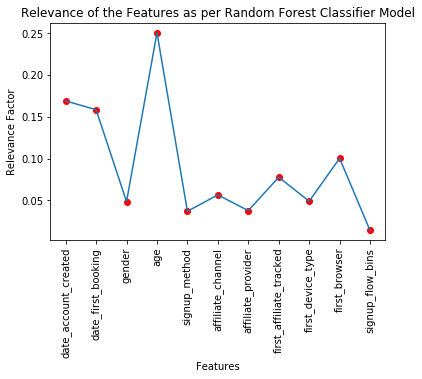

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.8s finished


Accuracy using Random Forest Classifier is : 56.83%
The confusion matrix is : 
 [[    0     1     0     2     3     3     2    74     4     1    68     4]
 [    1     4     7     5     6     6    11   186     6     1   179    16]
 [    0     4     2     2     4     3     4   148     2     2   133    14]
 [    7     4     5     6    19     9    13   324     4     2   266    16]
 [   10    18    17    24    20    19    24   728    10     6   578    53]
 [    5     6     6     9    11     9    11   349     7     0   261    23]
 [   10    12    10    13    11     4    10   424     6     2   326    23]
 [  193   303   276   325   353   330   327 28246   203   109  5958   740]
 [    2     3     1     3     3     5     2   106     1     0    89    14]
 [    0     0     0     1     0     5     3    30     0     0    25     1]
 [  100   221   203   240   288   220   241  8363   146    53  7984   654]
 [   13    43    25    48    40    34    33  1483    33    12  1153   111]]
Mean Absolute error

In [19]:
randomForestDecisionClassifier(df,df_test)

By using Random Forest Classifier , model has achieved 56.83% accuracy.

References

Repositories

https://github.com/karvenka/kaggle-airbnb/blob/master/notebooks/Venkatesan_Karthick_Final_Project_Report.ipynb

https://github.com/Sapphirine/Airbnb-New-User-Bookings-Prediction/blob/master/preprocessing%26prediction.ipynb

https://github.com/Currie32/AirBnB-Predicting-Destination/blob/master/Predicting_Destination.ipynb

Kaggle Competition

https://www.kaggle.com/meicher/predicting-first-destination-4-models

https://www.kaggle.com/svpons/three-level-classification-architecture

The code in the document by Kandarp Vyas is licensed under the MIT License https://opensource.org/licenses/MIT